In [1]:
train_counterfacts_data = "../temp_data/train_paired.tsv"
train_orig_data_url = "https://raw.githubusercontent.com/acmi-lab/counterfactually-augmented-data/master/sentiment/orig/eighty_percent/train.tsv"
test_orig_data_url = "https://raw.githubusercontent.com/acmi-lab/counterfactually-augmented-data/master/sentiment/orig/eighty_percent/test.tsv"




In [2]:
import sys, pandas as pd
import numpy as np
from functools import reduce 
from collections import Counter
pd.set_option('display.max_colwidth', 0)
sys.path.append("../src")
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from datetime import datetime

datefmt = datetime.now().strftime("%Y%m%d%H%M")



In [3]:
from utils.diff_dataset_counterfactuals import DiffDatasetCounterFactuals
from utils.diff_sentences import DiffSentences

words  = DiffDatasetCounterFactuals().compare(train_counterfacts_data)

In [4]:
words_all = reduce(lambda a, b: a+b, words)

In [5]:
df_word_feq = pd.DataFrame(Counter(words_all).most_common())
df_word_feq.columns = ["word", "freq"]
df_word_feq

,word,freq
0,not,1193
1,a,831
2,to,690
3,and,688
4,the,653
...,...,...
8446,ploddingly.,1
8447,unecessary,1
8448,depicting,1
8449,"""difficulties""",1


In [6]:
df_word_feq.query("freq > 5").sort_values(by=["freq"], ascending = False).head(n=50)

,word,freq
0,not,1193
1,a,831
2,to,690
3,and,688
4,the,653
5,but,642
6,of,485
7,bad,435
8,no,389
9,it,354


<AxesSubplot:ylabel='Frequency'>

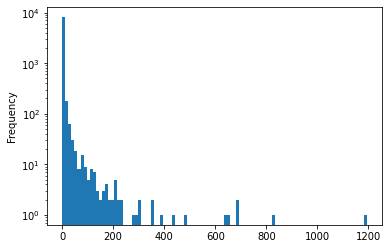

In [7]:
df_word_feq["freq"].plot.hist(bins=100, log=True)

In [8]:


def get_batch_id(df, df_counter_fact):
    dict_text_index = {}
    dict_batch_index = {}
    for r in df_counter_fact.to_dict('records'):
        dict_text_index[r["Text"]] = r["batch_id"]
        if  r["batch_id"] not in dict_batch_index: dict_batch_index[ r["batch_id"]] = {}
            
        counter_label = 'Negative' if r["Sentiment"] == 'Positive' else 'Positive'
        dict_batch_index[r["batch_id"]][counter_label] =  r["Text"]
    
    df["batch_id"] = df["Text"].apply(lambda x: dict_text_index.get(x, -1)).astype(int)
    df["counter_text"] = df.apply(lambda x: dict_batch_index.get(x["batch_id"], {}).get(x["Sentiment"], None), axis=1)
    df["counter_sentiment"] = df.apply(lambda x:('Negative' if x["Sentiment"] == 'Positive' else 'Positive')
                                       if x["counter_text"] else None , axis=1)
   



    return df

In [9]:
df_orig = pd.read_csv(train_orig_data_url, sep="\t")
df_orig

,Sentiment,Text,Length
0,Positive,Adrian Pasdar is excellent is this film. He makes a fascinating woman.,12
1,Positive,"This is the definitive movie version of Hamlet. Branagh cuts nothing, but there are no wasted moments.",17
2,Positive,"I don't know why I like this movie so well, but I never get tired of watching it.",18
3,Positive,"Obviously written for the stage. Lightweight but worthwhile. How can you go wrong with Ralph Richardson, Olivier and Merle Oberon.",20
4,Positive,"This movie will always be a Broadway and Movie classic, as long as there are still people who sing, dance, and act.",22
...,...,...,...
19257,Negative,"As someone who has both read the novel and seen the film, I have a different take on why the film was such a flop. First, any comparisons between novel and film are purely superficial. They are two different animals.<br /><br />The novel is probably intended as a satire, but it arrives as a cross between tragedy and polemic instead. Any comedic elements such as those which later formed the stylistic basis of the film version are merely incidental to the author's uniformly cynical thrust. And lest the omnipresent white suit of the author fool you into thinking this is another Mark Twain, think again. A more apt literary precedent would be the spectre of Ambrose Bierce in a top hat and tails. Tom Wolfe is equal parts clown and hack, more celebrity than author, always looking for new grist for his self-absorbed mill. <br /><br />It is therefore no wonder that the excellent production skills and direction lavished on the making of the film were doomed from the start. Unlike true satire, which translates very well into film, polemics are grounded not in universally accessible observations on some form or other of human behavior, but in a single-minded attack on specific people -- whether real or fictional straw men -- who have somehow earned the wrath of the writer. Any effort to create a successful filmed story or narrative from such a beginning must have a clean start, free of the writer's influence or interference.<br /><br />Having said that, I too find fault with the casting. It is not merely that incompetents like Bruce Willis and Melanie Griffith fail to measure up, but that real talents like Tom Hanks, F. Murray Abraham, and Morgan Freeman are either totally wasted or given roles that are mere caricatures.<br /><br />There is enough topical material here for a truly great film satire, but it fails to come even close.",317
19258,Negative,"Gung Ho was a good idea, however it is to much to ask Americans viewers to understand the dynamics of American jobs and foreign competition.In this movie the main character Hunt Stevenson(Michael Keaton) goes to Japan and convinces a Japanese auto company to come to America and help his dying Pennslyvania town. Two things come at you.First why would a Japanese company come to America to make cars when they do so ,and so well at that? Secondly can anyone understand that American companies of all types go to third world nations to have their products made to escape American labor costs? It makes the film's premise then that the Number one maker of cars in the world would go to one of its' top competitors(aside from Germany)and put a plant there as unrealistic. Keaton was still in his comedy mode by this time. But he gives a credible performance all the same as he could prove that he could go from comedy to drama in a matter of seconds and still not embarrass himself but Director Ron Howard can't keep this from becoming a TV movie which it ends up being anyway because they have to give the unlikely story a happy ending the politics and problems of Japanese and American relations not withstanding. Gung Ho has a Happy Days and Laverne and Shirley feel to it as the producers of both TV shows made the film and then made the TV version of this movie as well which gives the film its' lightweight feel.The Japanese manager gets to love his American workers and feels he and othe

In [10]:
df_counterfacts_train = pd.read_csv(train_counterfacts_data, sep="\t")
df_counterfacts_train.head()

,Sentiment,Text,batch_id
0,Negative,"Long, boring, blasphemous. Never have I been so glad to see ending credits roll.",4
1,Positive,"Long, fascinating, soulful. Never have I been so sad to see ending credits roll.",4
2,Negative,Not good! Rent or buy the original! Watch this only if someone has a gun to your head and then....maybe.<br /><br />It is like claiming an Elvis actor is as good as the real King.,40
3,Positive,"So good! Rent or buy the original, too! Watch this, too! It's just as good!<br /><br />It is an amazing Elvis impersonator and the real King.",40
4,Negative,"This movie is so bad, it can only be compared to the all-time worst ""comedy"": Police Academy 7. No laughs throughout the movie. Do something worthwhile, anything really. Just don't waste your time on this garbage.",47


In [11]:
df_counterfacts_train.shape

(3414, 3)

In [12]:
df_orig = df_orig.pipe(get_batch_id, df_counterfacts_train)

In [13]:

df_orig_train, df_orig_val = train_test_split(df_orig, test_size=0.2, random_state=42)
df_orig_train.shape, df_orig_val.shape

((15409, 6), (3853, 6))

In [14]:
df_orig_train.sample(n=10)

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
2572,Positive,"what can i say?, ms Erika Eleniak is my favorite blonde girl ever, and like a Italian American, fan number one of female beauty i can't forget this movie.<br /><br />you know i really don't remember a lot about the plot, or the situations or the other actors . i only can remember about drop dead gorgeous Erika and that in this film she looks better than ever, i really don't care if it was a bad movie or a good movie, i only care the nice moments i had been a teenager in Brooklyn just contemplating Erika's beauty.<br /><br />Well just to conclude if you are an Erika Eleniak's beauty fan like me definitely this film is for you.",120,15169,"What can I say? Ms. Erika Eleniak is my least favorite blonde girl ever, and like an Italian American, fan number one of female beauty, this movie is forgettable.<br /><br />You know I really don't remember a lot about the plot, or the situations, or the other actors. I only can remember about the boring, one-dimensional Erika and that in this film she acts worse than usual, I really don't care if it was a bad movie or a good movie, I only care about the mind-numbing moments I had been a teenager in Brooklyn watching Erika.<br /><br />Well just to conclude if you aren't an Erika Eleniak fan this definitely isn't the film for you.",Negative
8382,Positive,"During the opening night of the Vanties a woman is found dead on the catwalk above the stage. As the show continues the police attempt to piece together who killed who and why before the final curtain.<br /><br />I had always heard that this was a great classic comedy mystery so I was excited to find myself a copy. Unfortunately no one told me about the musical numbers which go on and on and on. While the numbers certainly are the type that Hollywood did in their glory days, they become intrusive because they pretty much stop the movie dead despite attempts to weave action around them. This wouldn't be so bad if the music was half way decent, but its not. There is only one good song. Worse its as if the studio knew they had one song, Cocktails for Two, and we're forced to endure four versions of it: a duet, a big production number, as the Vanities finale and in the background as incidental music. I don't think Spike Jones and His City Slickers ever played it that much. The rest of the movie is pretty good with Victor McLaglen sparring nicely with Jack Oakie. Charles Middleton is very funny is his scenes as an actor in love with the wardrobe mistress.<br /><br />By no mean essential I can recommend this if you think you can get through the musical numbers, or are willing to scan through them. Its a fun movie of the sort they don't make any more.",253,-1,None,None
8752,Positive,"I gather from reading the previous comments that this film went straight to cable. Well, I paid to see it in a theatre, and I'm glad I did because visually it was a striking film. Most of the settings seem like they were made in the early 60s (except for the shrink's office, which was dated in a different way), and if you leave the Neve Campbell sequences out, the whole film has a washed- out early 60s ambience. And the use of restaurants in the film was fascinating. For a first-time director whose background, I believe, is in writing, he has a great eye. Within the first ten minutes I felt the plot lacked plausibility, so I just willingly suspended my disbelief and went along for the ride. In terms of acting and the depiction of father-son, mother-son, husband-wife, parent-child relationships, the film was spot-on. William H. Macy, a pleasure to watch, seems to be filling the void left by the late Tony Perkins, if this and Magnolia are any indication. Tracey Ullman as the neglected wife was quite moving, to me. It was a three-dimensional depiction of a character too often viewed by society as two-dimensional. Of course, Donald Sutherland can add this to his collection of unforgettable portraya

In [15]:
(df_orig_train["batch_id"]!=-1).value_counts()

False    14020
True     1389 
Name: batch_id, dtype: int64

In [16]:
df_orig_train[df_orig_train["batch_id"]==-1]

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
4448,Positive,"I love this anime! I was laughing my head off with all of the jokes and the violence (mostly from Akane Ranma's reluctant but short tempered ""fiancee"")is so slapstick however Ranma does deserve it but he does try his best to make amends...clumsily. The main character Ranma goes to China to train only to fall into the cursed Jusenkkyo Spring and turns into a girl when splashed by cold water. From then on it's pure chaos one after another. Among the stand outs are the deranged brother and sister duo of Kuno and Kodachi, the sexy Shampoo, the pervert Happosai all causing trouble for our hero/heroine. However it is Ranma's selfish father Genma who winds up being the culprit for the mess most of the time. If anyone want an anime that's funny, this is the one. It's cuter and better with the Japanese dub.",145,-1,None,None
4132,Positive,"Melvyn Douglas once more gives a polished performance in which, this time, he inhabits the role of a detective who can't place love before duty and adventure, and the warmly beautiful Joan Blondell (who, far from being illiterate, as one reviewer suggested, wrote a novel about her early life) is as enjoyable as ever as his ever-suffering sweetheart.It's almost a screwball comedy, almost a Thin Man-type movie, almost a series, I guess, that didn't quite make it to a sequel. It doesn't quite reach classic status, but it has all the ingredients for a fun 85 minutes with an episodic but pacey script, fine character actors, and direction that keeps it all moving fast enough so that you nearly don't notice that Williams (Douglas) isn't exactly Columbo when it comes to detecting. I wish there were more films like this.",140,-1,None,None
7007,Positive,"First of all, this film was not released to theatres (TESTED POORLY THEY SAY),I say they figured the story of crooked cops, politicians & dedicated newspaper people had been done to death,just send it DVD & cable TV> & take the money & run.<br /><br />That being said I usually like this type of movie, especially with this named cast. Morgan Freeman, Justin Timberlake, Kevin Spacey,<br /><br />L.L.Cool J, Cary Elways, John Heard & on the distaff side, Piper Perabo & Roslyn Sanchez.<br /><br />The plot & story have been done to death, BUT the above cast brings life to this violent movie & it is actually watchable.<br /><br />Justin Timberlake Is good as the dedicated young reporter for a throw-away newspaper edited by Morgan Freeman, The others are either crooked Cops,& Politicians or somewhat decent guys, The 2 ladies are the girl friends of LL COOL J & JUSTIN TIMBERLAKE & do whats required, It is quite violent, many killings etc, not for children. By no means is the a great film, BUT for what it is & the cast It is definitely good,<br /><br />Ratings *** (out of 4) 86 points (out of 100) IMDb 8 (out of 10)",201,-1,None,None
11838,Negative,"I had the displeasure of watching this movie with my girlfriend, who, like me, is a fan of the first. This movie down right sucked! It lacked the magic of the first. You could actually understand every word the mice said, the animation is crappy, the palace is much much different from the first movie, there's new characters that were never mentioned before and were terrible, luckily the Prince didn't have many lines which kept him from sounding stupid. Basically its like The Lion King 1 1/2 except its different stories all told by the mice. The reason I'm giving this a 2 out of 10 is because the songs not sung by the characters were the most enjoyable.",119,-1,None,None
5689,Positive,"It is written in stone that Disney animations simply ~must~ be musicals. Right? Where? Show me. Because I found this attempt to be much more enjoyable for ~not~ containing the hokey made-for-five-year-old standard Disney musical fare. <br /><br />While the story was not as enthralling as it could have been, it was still quite good, enjoyable, and adventurous. I had 

In [17]:
df_orig_train[df_orig_train["Text"].isin(df_orig_train["counter_text"])]

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
1406,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
1404,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
18135,Negative,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a taste for Human Flesh... Then a Crack team, who might as well be called Delta Force get called in.<br /><br />OK, This ain't Jurassic Park, and Yes The Dino's are never clearly seen because it's obviously a guy in a Costume that's not too dissimilar to Barney the Dinosaur - only slightly LESS terrifying,but come on guys this had about 1% of Jurassic Park's Budget and as such does what it can.<br /><br />Does this deserve to be in the bottom 100?....HELL NO!!! I think the nearly half of voters who give this a 1 - are being WAY WAY overly harsh, it's much closer to a 4... it's actually a lot better than a whole host of other movies not in the Bottom 100, and has a similar production value to a Sci-Fi Channel Production. (again Movies which get a overly harsh time from critics here on IMDb)<br /><br />The acting is as expected in a B Movie although none of the actors take it that seriously, neither does the script<br /><br />All in All it's an enjoyable B Movie - Not for Film Snobs<br /><br />** out of *****",251,8822,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a tas

In [18]:
df_orig_train[df_orig_train["counter_text"].isin(df_orig_train["Text"])]

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
1406,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
1404,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
18135,Negative,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a taste for Human Flesh... Then a Crack team, who might as well be called Delta Force get called in.<br /><br />OK, This ain't Jurassic Park, and Yes The Dino's are never clearly seen because it's obviously a guy in a Costume that's not too dissimilar to Barney the Dinosaur - only slightly LESS terrifying,but come on guys this had about 1% of Jurassic Park's Budget and as such does what it can.<br /><br />Does this deserve to be in the bottom 100?....HELL NO!!! I think the nearly half of voters who give this a 1 - are being WAY WAY overly harsh, it's much closer to a 4... it's actually a lot better than a whole host of other movies not in the Bottom 100, and has a similar production value to a Sci-Fi Channel Production. (again Movies which get a overly harsh time from critics here on IMDb)<br /><br />The acting is as expected in a B Movie although none of the actors take it that seriously, neither does the script<br /><br />All in All it's an enjoyable B Movie - Not for Film Snobs<br /><br />** out of *****",251,8822,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a tas

In [19]:
df_orig_train.query("Text == counter_text")

,Sentiment,Text,Length,batch_id,counter_text,counter_sentiment
1406,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
1404,Positive,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",93,13959,"THE JIST: See something else.<br /><br />This film was highly rated by Gene Siskel, but after watching it I can't figure out why. The film is definitely original and different. It even has interesting dialogue at times, some cool moments, and a creepy ""noir"" feel. But it just isn't entertaining. It also doesn't make a whole lot of sense, in plot but especially in character motivations. I don't know anyone that behaves like these characters do.<br /><br />This is a difficult movie to take on -- I suggest you don't accept the challenge.",Negative
18135,Negative,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a taste for Human Flesh... Then a Crack team, who might as well be called Delta Force get called in.<br /><br />OK, This ain't Jurassic Park, and Yes The Dino's are never clearly seen because it's obviously a guy in a Costume that's not too dissimilar to Barney the Dinosaur - only slightly LESS terrifying,but come on guys this had about 1% of Jurassic Park's Budget and as such does what it can.<br /><br />Does this deserve to be in the bottom 100?....HELL NO!!! I think the nearly half of voters who give this a 1 - are being WAY WAY overly harsh, it's much closer to a 4... it's actually a lot better than a whole host of other movies not in the Bottom 100, and has a similar production value to a Sci-Fi Channel Production. (again Movies which get a overly harsh time from critics here on IMDb)<br /><br />The acting is as expected in a B Movie although none of the actors take it that seriously, neither does the script<br /><br />All in All it's an enjoyable B Movie - Not for Film Snobs<br /><br />** out of *****",251,8822,"Primal Species comes from B Movie legend Roger Corman and as such everybody who watches this needs to realise that this is a Low Budget B Movie and it knows it.<br /><br />A bunch of terrorists high-jack a Lorry and kill an entire army doing so, they believe it to hold uranium, but No..... It contains two Dino's with a tas

In [20]:
def _compute_affablity_rate(samples, threshold):
    aff_diff = DiffSentences().pairwise_edit_distance_ratio(list(samples), list(samples), score_cutoff=0)
    
    # Set max distance in diagnoals so that it doesnt come up as the closest match
    for i in range(len(aff_diff)):
        aff_diff[i,i]=1000
    
    closest_match = np.min(aff_diff, axis=-1)
    closest_match_idx = np.argmin(aff_diff, axis=-1)
    aff_diff_min = [ 1 for i in closest_match if i < threshold ]
    aff_rate = sum(aff_diff_min) / len(samples)
    
    debug_df = pd.DataFrame(samples)
    debug_df["closest_dist"] = closest_match
    debug_df["closest_match"] = [list(samples)[i] for i in closest_match_idx]
    
    return aff_rate, debug_df
    
def _compute_adv_rate(samples1, samples2, threshold):
    adv_diff = DiffSentences().pairwise_edit_distance_ratio(list(samples1), list(samples2), score_cutoff=0)

    closest_match = np.min(adv_diff, axis=-1)
    closest_match_idx = np.argmin(adv_diff, axis=-1)
    
    # Adv P -> N debug info
    debug_df = pd.DataFrame(samples1)
    debug_df["closest_dist"] = closest_match
    debug_df["closest_match"] = [list(samples2)[i] for i in closest_match_idx]
    
    adv_diff_min = [ 1 for i in closest_match if i < threshold ]
    adv_rate = sum(adv_diff_min) / len(samples1)
    
    return adv_rate, debug_df

    
def get_stats(df, threshold_adv=.25, threshold_aff=.50):
    num_unique = df["Text"].nunique()
    pos_ratio = len(df.query("Sentiment == 'Positive'"))/len(df)
    pos_texts = df.query("Sentiment == 'Positive'")["Text"]
    neg_texts = df.query("Sentiment == 'Negative'")["Text"]

    pos_adv_rate, adv_debug = _compute_adv_rate(pos_texts, neg_texts, threshold_adv)
    pos_aff_rate, aff_pos_debug = _compute_affablity_rate(pos_texts, threshold_aff)

    neg_aff_rate, neg_pos_debug = _compute_affablity_rate( neg_texts, threshold_aff)


        
    result = {
        "Unique" : num_unique,
        "PosRate": pos_ratio,
        "AdvRatePN" : pos_adv_rate,
        "AffRateP": pos_aff_rate,
        "AffRateN": neg_aff_rate,
        "Total" : len(df)
    }
    
    debug = {
        "adv_p_n" : adv_debug,
        "aff_p" : aff_pos_debug,
        "aff_n" : neg_pos_debug
    }
    
    
    return result, debug

In [21]:
%%time

counterfact_stats, counterfact_debug = get_stats(df_counterfacts_train)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


CPU times: user 8min 25s, sys: 1.82 s, total: 8min 27s
Wall time: 8min 29s


In [22]:
counterfact_stats

{'Unique': 3413,
 'PosRate': 0.5,
 'AdvRatePN': 0.929701230228471,
 'AffRateP': 0.0,
 'AffRateN': 0.0,
 'Total': 3414}

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.2)

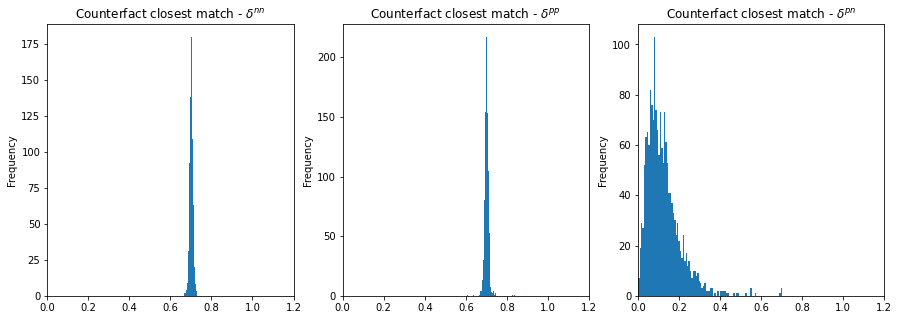

In [23]:
_, ax = plt.subplots(1,3,  figsize=(15,5))


counterfact_debug["aff_n"]["closest_dist"].plot.hist(bins=100, ax=ax[0],  title = "Counterfact closest match - $\delta^{nn}$")
ax[0].set_xlim(0, 1.2)

counterfact_debug["aff_p"]["closest_dist"].plot.hist(bins=100, ax=ax[1],  title = "Counterfact closest match - $\delta^{pp}$")
ax[1].set_xlim(0, 1.2)


counterfact_debug["adv_p_n"]["closest_dist"].plot.hist(bins=100, ax=ax[2],  title = "Counterfact closest match - $\delta^{pn}$")
ax[2].set_xlim(0, 1.2)


In [24]:
def prep_counterfactual(df, adv_rate_pos=0.1, total_size=3400):
    
    pos_rate = 0.5
    
    neg_samples = int(total_size * (1-pos_rate))
    

    pos_samples = total_size - neg_samples
    adv_neg_samples = int(adv_rate_pos * pos_samples)
    non_adv_neg_samples = neg_samples - adv_neg_samples
    
    
    df_pos_with_cf = df.query("batch_id != -1 and Sentiment == 'Positive'")
    
    # Get n positives
    pos_samp_with_adv_size = min(len(df_pos_with_cf), pos_samples)
    df_pos_with_adv = df_pos_with_cf.sample(n=pos_samp_with_adv_size)
    df_pos_without_adv = df.query("batch_id == -1 and Sentiment == 'Positive'")\
                [["Sentiment", "Text", "batch_id"]].sample(n=pos_samples - pos_samp_with_adv_size)


        
    # Get paired n negatives
    df_paired = df_pos_with_adv.sample(n=adv_neg_samples)
    df_adv_neg = df_paired[["counter_sentiment", "counter_text" , "batch_id" ]]
    df_adv_neg.columns = ["Sentiment", "Text", "batch_id"]

    # Random neg
    df_neg_random = df.query("batch_id == -1 and Sentiment == 'Negative'")\
                    [["Sentiment", "Text", "batch_id"]].sample(n=non_adv_neg_samples).copy()
    
    return pd.concat([df_adv_neg, df_pos_with_adv[["Sentiment", "Text", "batch_id"]] ,
                      df_pos_without_adv, df_neg_random])

    
    
    


In [25]:
%%time

ADV_R_PN = 0.10

df_train_prepared = prep_counterfactual(df_orig_train, adv_rate_pos=ADV_R_PN, total_size=3400)   

result_train_stats, train_debug = get_stats(df_train_prepared, threshold_adv=0.25, threshold_aff=0.50)
print(result_train_stats)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'Unique': 3392, 'PosRate': 0.5, 'AdvRatePN': 0.09588235294117647, 'AffRateP': 0.0058823529411764705, 'AffRateN': 0.0035294117647058825, 'Total': 3400}
CPU times: user 6min 53s, sys: 2.21 s, total: 6min 55s
Wall time: 10min 42s


In [26]:
%%time

df_val_prepared = prep_counterfactual(df_orig_val, adv_rate_pos=ADV_R_PN, total_size=int(3400*0.2)  )

result_val_stats, val_debug = get_stats(df_val_prepared, threshold_adv=0.25, threshold_aff=0.50)
print(result_val_stats)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aparnaelangovan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'Unique': 680, 'PosRate': 0.5, 'AdvRatePN': 0.09705882352941177, 'AffRateP': 0.0, 'AffRateN': 0.0, 'Total': 680}
CPU times: user 14.2 s, sys: 49 ms, total: 14.2 s
Wall time: 14.4 s


/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.2)

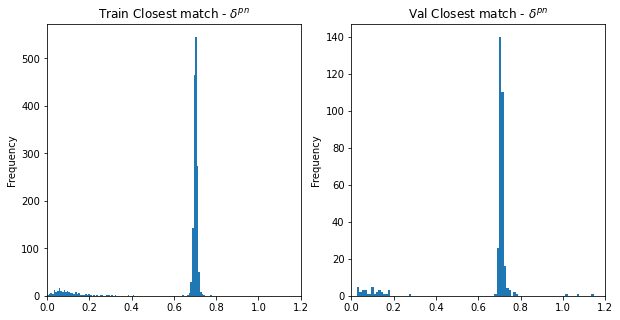

In [27]:
_, ax = plt.subplots(1,2, figsize=(10,5))
train_debug["adv_p_n"]["closest_dist"].plot.hist(bins=100, ax=ax[0], title = "Train Closest match - $\delta^{pn}$")
ax[0].set_xlim(0, 1.2)

val_debug["adv_p_n"]["closest_dist"].plot.hist(bins=100, ax=ax[1], title = "Val Closest match - $\delta^{pn}$")
ax[1].set_xlim(0, 1.2)

(0.0, 1.2)

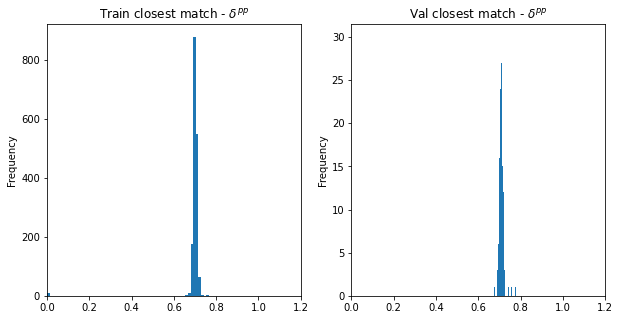

In [28]:
_, ax = plt.subplots(1,2,  figsize=(10,5))


train_debug["aff_p"]["closest_dist"].plot.hist(bins=100, ax=ax[0],  title = "Train closest match - $\delta^{pp}$")
ax[0].set_xlim(0, 1.2)

val_debug["aff_p"]["closest_dist"].plot.hist(bins=100, ax=ax[1], title = "Val closest match - $\delta^{pp}$")
ax[1].set_xlim(0, 1.2)

(0.0, 1.2)

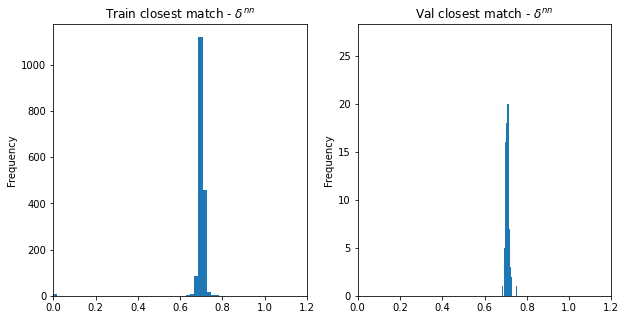

In [29]:
_, ax = plt.subplots(1,2,  figsize=(10,5))


train_debug["aff_n"]["closest_dist"].plot.hist(bins=100, ax=ax[0],  title = "Train closest match - $\delta^{nn}$")
ax[0].set_xlim(0, 1.2)

val_debug["aff_n"]["closest_dist"].plot.hist(bins=100, ax=ax[1], title = "Val closest match - $\delta^{nn}$")
ax[1].set_xlim(0, 1.2)



In [30]:
import sagemaker, io, json


def upload_df_to_s3(df, s3_dest):
    b = io.StringIO()
    df.to_json(b)
    
    print(f"Uploading {s3_dest}")
    
    sagemaker.s3.S3Uploader.upload_string_as_file_body(b.getvalue(), s3_dest)
    
def upload_json_to_s3(json_obj, s3_dest):
    b = io.StringIO()
    json.dump(json_obj, b)
    
    print(f"Uploading {s3_dest}")
    
    sagemaker.s3.S3Uploader.upload_string_as_file_body(b.getvalue(), s3_dest)
 
s3_prefix =  "s3://aegovan-data/counterfactuals/imdb/{}/{}_{}_{}".format(datefmt,
                                                                    int(result_train_stats["AdvRatePN"]*100)
                                                                    , int(result_train_stats["AffRateP"]*100)
                                                                    ,int(result_train_stats["AffRateN"]*100))

upload_df_to_s3(df_train_prepared.reset_index(),   f"{s3_prefix}/train.json")
upload_json_to_s3(result_train_stats,   f"{s3_prefix}/stats/train_stats.json")

upload_df_to_s3(df_val_prepared.reset_index(),   f"{s3_prefix}/val.json")
upload_json_to_s3(result_val_stats,   f"{s3_prefix}/stats/val_stats.json")

upload_df_to_s3( pd.read_csv(test_orig_data_url, sep="\t"), f"{s3_prefix}/test.json")

Uploading s3://aegovan-data/counterfactuals/imdb/202304081856/9_0_0/train.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304081856/9_0_0/stats/train_stats.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304081856/9_0_0/val.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304081856/9_0_0/stats/val_stats.json
Uploading s3://aegovan-data/counterfactuals/imdb/202304081856/9_0_0/test.json


In [31]:
df_train_prepared.reset_index().sample(n=10).to_json("sample_counterfact_imdb.json")